In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
picture_size = 48
folder_path = "../input/face-expression/multi_modal/"

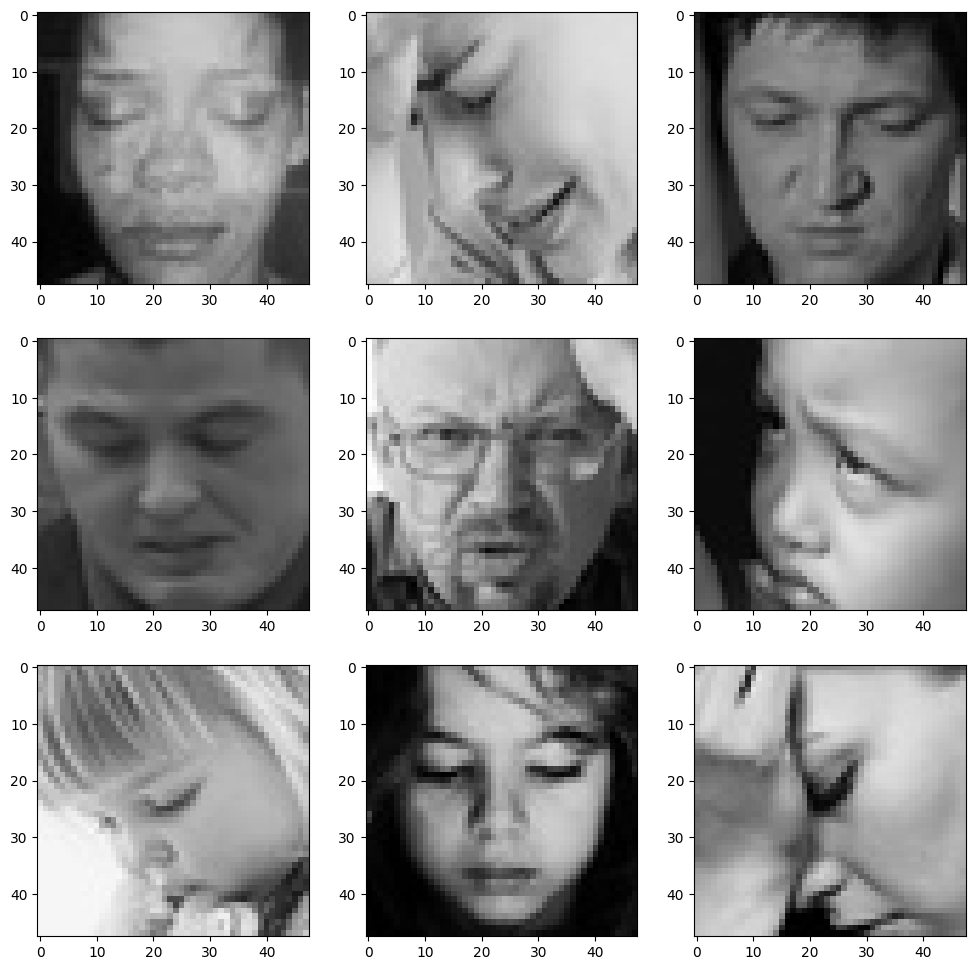

In [3]:
expression = 'sad'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

In [4]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        folder_path+"train",
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        folder_path+"test",
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28385 images belonging to 6 classes.
Found 6955 images belonging to 6 classes.


In [5]:
print(len(train_generator))
print(len(validation_generator))

444
109


In [6]:
# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(6, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

In [7]:
# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28385 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=6955 // 64)

Epoch 1/50


/tmp/ipykernel_1644/3139131509.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(
2024-01-04 11:29:53.922385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


443/443 [==============================] - 36s 70ms/step - loss: 1.6413 - accuracy: 0.3210 - val_loss: 1.4064 - val_accuracy: 0.4414
Epoch 2/50
443/443 [==============================] - 29s 66ms/step - loss: 1.3523 - accuracy: 0.4647 - val_loss: 1.2334 - val_accuracy: 0.5139
Epoch 3/50
443/443 [==============================] - 31s 69ms/step - loss: 1.2314 - accuracy: 0.5177 - val_loss: 1.1483 - val_accuracy: 0.5548
Epoch 4/50
443/443 [==============================] - 30s 67ms/step - loss: 1.1628 - accuracy: 0.5485 - val_loss: 1.1271 - val_accuracy: 0.5667
Epoch 5/50
443/443 [==============================] - 30s 68ms/step - loss: 1.1172 - accuracy: 0.5651 - val_loss: 1.0939 - val_accuracy: 0.5768
Epoch 6/50
443/443 [==============================] - 29s 65ms/step - loss: 1.0639 - accuracy: 0.5888 - val_loss: 1.0675 - val_accuracy: 0.5958
Epoch 7/50
443/443 [==============================] - 31s 70ms/step - loss: 1.0330 - accuracy: 0.6004 - val_loss: 1.0490 - val_accuracy: 0.6036
Epo

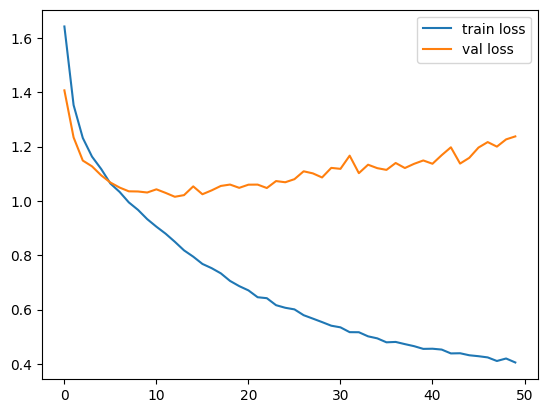

In [9]:
# loss
plt.plot(emotion_model_info.history['loss'], label='train loss')
plt.plot(emotion_model_info.history['val_loss'], label='val loss')
plt.legend()
plt.show()

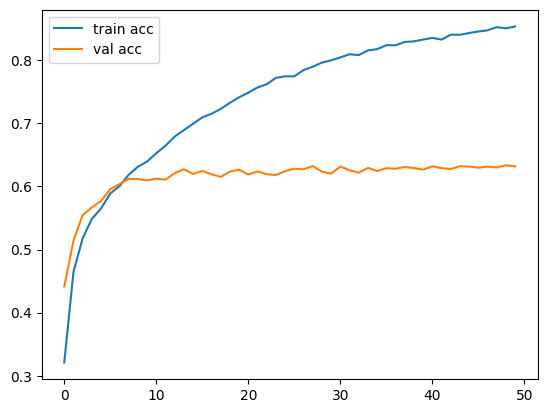

In [10]:
# accuracies
plt.plot(emotion_model_info.history['accuracy'], label='train acc')
plt.plot(emotion_model_info.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [11]:
# save model structure in jason file
model_json = emotion_model.to_json()
with open("face_emotion.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('face_emotion.h5')

In [12]:
lab = train_generator.class_indices
lab={k:v for v,k in lab.items()}
print(lab)

{0: 'angry', 1: 'fear', 2: 'happy', 3: 'neutral', 4: 'sad', 5: 'surprise'}


In [13]:
from keras.models import model_from_json
# load json and create model
json_file = open('./face_emotion.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# load weights into new model
emotion_model.load_weights("./face_emotion.h5")

In [18]:
def predict_emotion(image_path):
    # Load the image
    img = load_img(image_path, target_size=(48, 48), grayscale=True)

    # Display the loaded image
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    # Convert the image to a numpy array
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the pixel values
    img_array /= 255.0

    # Make predictions using the loaded model
    emotion_prediction = emotion_model.predict(img_array)

    # Get the predicted emotion label
    emotion_labels = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    predicted_emotion_index = np.argmax(emotion_prediction)
    predicted_emotion_label = emotion_labels[predicted_emotion_index]

    # Display the predicted emotion
    print(f"Predicted Emotion: {predicted_emotion_label}")


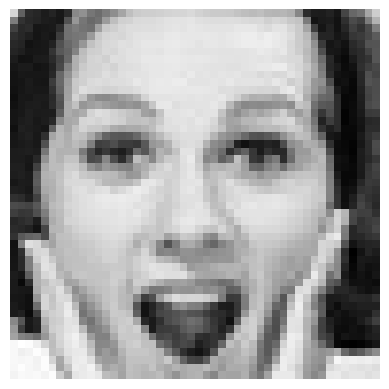

1/1 [==============================] - 0s 23ms/step
Predicted Emotion: Surprise


In [19]:
# Call the function with the path to your image
image_path = '../input/face-expression/multi_modal/train/surprise/10011.jpg'  
predict_emotion(image_path)

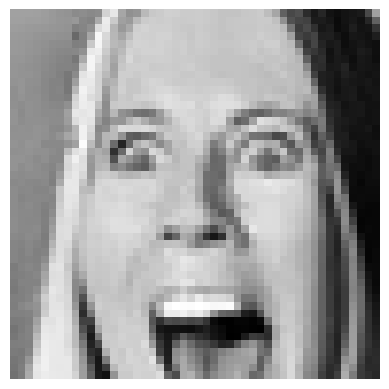

1/1 [==============================] - 0s 37ms/step
Predicted Emotion: Fear


In [20]:
# Call the function with the path to your image
image_path = '../input/face-expression/multi_modal/train/fear/10047.jpg'  
predict_emotion(image_path)